In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("SunLab_Faro_Cleaned_mjs.csv", parse_dates=['Datetime'])

In [4]:
# https://pandas.pydata.org/docs/reference/series.html

# Add day of year as int
df['day_of_year'] = df['Datetime'].dt.dayofyear

# Convert hour and minute to float rounded to three decimal places
df['hour_and_minute'] = (df['Datetime'].dt.hour + (df['Datetime'].dt.minute / 60)).round(3)

display(df[['Datetime', 'day_of_year', 'hour_and_minute']].head())

,Datetime,day_of_year,hour_and_minute
0,2014-01-01 07:41:00,1,7.683
1,2014-01-01 07:42:00,1,7.700
2,2014-01-01 07:43:00,1,7.717
3,2014-01-01 07:44:00,1,7.733
4,2014-01-01 07:45:00,1,7.750


,Datetime,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],B_Optimal - Voltage DC [V],B_Optimal - Current DC [A],B_Optimal - Power DC [W],B_Optimal - Temperature [C],Ambient Temperature [C],Global Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Deg],Precipitation [mm],day_of_year,hour_and_minute
0,2014-01-01 07:41:00,14.6,0.19527,2.850946,9.4,0.00,0.000000,0.000000,9.7,9.7,7.131149,0.751824,0.700000,275.33384,0.0,1,7.683
1,2014-01-01 07:42:00,23.1,0.07250,1.674750,9.4,18.30,0.130512,2.388366,9.7,9.7,7.040442,0.781930,0.666667,278.50306,0.0,1,7.700
2,2014-01-01 07:43:00,23.1,0.07500,1.732500,9.4,22.35,0.052500,1.173375,9.7,9.7,6.594407,0.813929,0.616667,284.66712,0.0,1,7.717
3,2014-01-01 07:44:00,23.1,0.07750,1.790250,9.5,24.35,0.052500,1.278375,9.7,9.7,7.358729,0.849919,0.666667,278.66666,0.0,1,7.733
4,2014-01-01 07:45:00,22.2,0.08250,1.831500,9.5,25.25,0.052500,1.325625,9.7,9.7,7.470711,0.886891,0.633333,272.66636,0.0,1,7.750


Datetime                       datetime64[ns]
A_Optimal - Voltage DC [V]            float64
A_Optimal - Current DC [A]            float64
A_Optimal - Power DC [W]              float64
A_Optimal - Temperature [C]           float64
B_Optimal - Voltage DC [V]            float64
B_Optimal - Current DC [A]            float64
B_Optimal - Power DC [W]              float64
B_Optimal - Temperature [C]           float64
Ambient Temperature [C]               float64
Global Radiation [W/m2]               float64
Ultraviolet [W/m2]                    float64
Wind Velocity [m/s]                   float64
Wind Direction [Deg]                  float64
Precipitation [mm]                    float64
day_of_year                             int32
hour_and_minute                       float64
dtype: object


<Axes: >

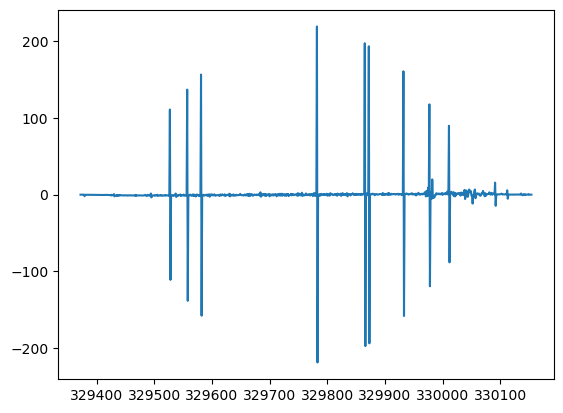

In [5]:
display(df.head())

print(df.dtypes)

df_temp = df.copy()

# Show wattage for a random day
df_temp['A_Optimal - Power DC [W]_diff'] = df_temp['A_Optimal - Power DC [W]'] - df_temp['A_Optimal - Power DC [W]'].shift(-1)
df_plot = df_temp.loc[(df_temp['Datetime'].dt.year == 2015) & (df_temp['day_of_year'] == 103)].copy()
df_plot['A_Optimal - Power DC [W]_diff'].plot()

We see spikes to zero.  This is likely an error in the reading so if both adjacent readings are non-zero, average these to smooth the data.

This will change fewer values than doing an SMA, which would still factor in the zero

<Axes: >

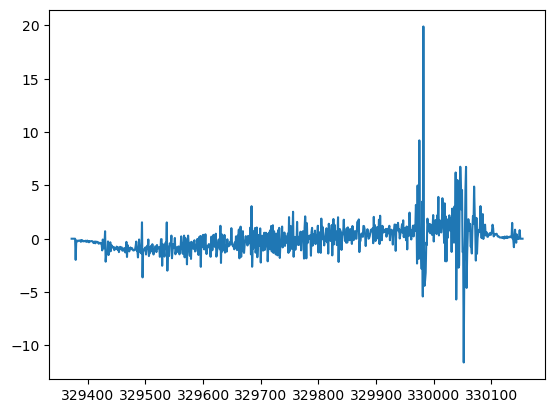

In [6]:
# If the reading is zero but the adjacent values are greater than zero, assume this is an error and average the two adjacent points

for col_name in list(df):
    if df[col_name].dtype == 'float64':
        df[col_name] = np.where(\
                            (df[col_name] == 0) & \
                            (df[col_name].shift(1) > 0) & \
                            (df[col_name].shift(-1) > 0), \
                            (df[col_name].shift(1) + df[col_name].shift(-1)) / 2, \
                            df[col_name])


# Show wattage for a random day
df_temp = df.copy()
df_temp['A_Optimal - Power DC [W]_diff'] = df_temp['A_Optimal - Power DC [W]'] - df_temp['A_Optimal - Power DC [W]'].shift(-1)
df_plot = df_temp.loc[(df_temp['Datetime'].dt.year == 2015) & (df_temp['day_of_year'] == 103)].copy()
df_plot['A_Optimal - Power DC [W]_diff'].plot()


Still some variability but much improved

In [7]:
# This function will shift the values in column named col_name by a number of minutes for creating additional y values
# We will do a 15 minute, 60 minute, and 1 day model
def shift_col_by_minutes(df, col_name, minute_shift):
    # Initial copy of dataframe with all columnm
    df_temp = df.copy()
    # Second copy of dataframe where we shift the columns
    df_temp_shift = df[['Datetime', col_name]].copy()

    # Shift time by minutes specified in parameters
    df_temp_shift['Datetime'] = df_temp_shift['Datetime'] - pd.Timedelta(minutes=minute_shift)

    # Create new column name for value being shifted and rename
    col_name_shift = col_name + '_shift_' + str(minute_shift)
    df_temp_shift.rename(columns={col_name : col_name_shift}, inplace=True)

    # Merge shifted dataframe with existing
    df_temp = pd.merge(df_temp, df_temp_shift[['Datetime', col_name_shift]], on='Datetime', how='left')

    # If we only shift by 15 or 60 minutes, we are concerned with the same day.  This will create values that are NaN at the end of the day
    # If we notice this we can assume these are zero as these are after the plant stopped generating data
    if minute_shift < 1440:
        df_temp[col_name_shift] = np.where(~(df_temp['Datetime'] + pd.Timedelta(minutes=minute_shift)).isin(df_temp['Datetime']), 0, df_temp[col_name_shift])

    return df_temp

In [8]:
# def add_y_by_minutes_shift(df, col_name, minute_shift):
for minute_shift in [15, 60, 1440]:
    for col_name in ['A_Optimal - Power DC [W]', 'B_Optimal - Power DC [W]']:
        print(f"Shifting {col_name} by {minute_shift} minutes")
        df = shift_col_by_minutes(df, col_name, minute_shift)


Shifting A_Optimal - Power DC [W] by 15 minutes
Shifting B_Optimal - Power DC [W] by 15 minutes
Shifting A_Optimal - Power DC [W] by 60 minutes
Shifting B_Optimal - Power DC [W] by 60 minutes
Shifting A_Optimal - Power DC [W] by 1440 minutes
Shifting B_Optimal - Power DC [W] by 1440 minutes


<Axes: >

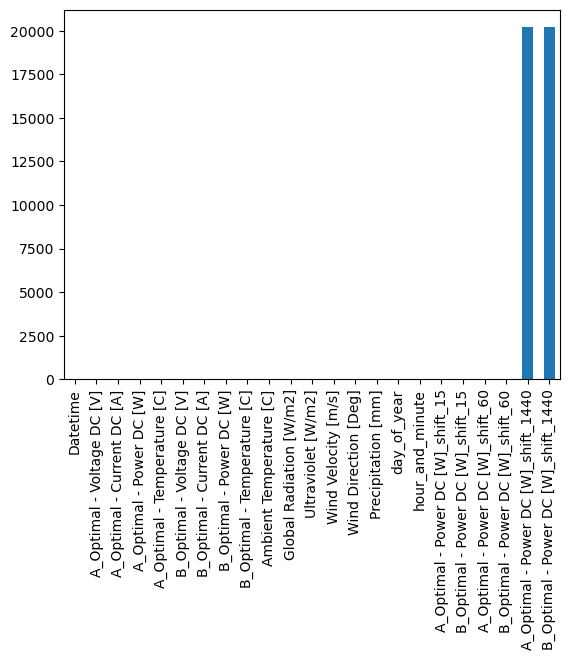

In [9]:
# display(df.head(10))
# display(df.tail(10))

df.isna().sum().plot.bar()

Looks like we have ~20,000 NaN for the one day model, we will drop these when splitting out and training but will keep for now so we don't lose any data for the 15 and 60 minute models

In [10]:
display(df.head())
display(df.tail())

,Datetime,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],B_Optimal - Voltage DC [V],B_Optimal - Current DC [A],B_Optimal - Power DC [W],B_Optimal - Temperature [C],Ambient Temperature [C],...,Wind Direction [Deg],Precipitation [mm],day_of_year,hour_and_minute,A_Optimal - Power DC [W]_shift_15,B_Optimal - Power DC [W]_shift_15,A_Optimal - Power DC [W]_shift_60,B_Optimal - Power DC [W]_shift_60,A_Optimal - Power DC [W]_shift_1440,B_Optimal - Power DC [W]_shift_1440
0,2014-01-01 07:41:00,14.6,0.19527,2.850946,9.4,0.00,0.000000,0.000000,9.7,9.7,...,275.33384,0.0,1,7.683,9.204125,5.853375,53.968500,50.405000,NaN,NaN
1,2014-01-01 07:42:00,23.1,0.07250,1.674750,9.4,18.30,0.130512,2.388366,9.7,9.7,...,278.50306,0.0,1,7.700,11.490500,7.816500,57.513250,53.742375,NaN,NaN
2,2014-01-01 07:43:00,23.1,0.07500,1.732500,9.4,22.35,0.052500,1.173375,9.7,9.7,...,284.66712,0.0,1,7.717,13.160000,10.233500,58.007250,54.104750,NaN,NaN
3,2014-01-01 07:44:00,23.1,0.07750,1.790250,9.5,24.35,0.052500,1.278375,9.7,9.7,...,278.66666,0.0,1,7.733,14.718750,11.513250,59.020750,54.782000,NaN,NaN
4,2014-01-01 07:45:00,22.2,0.08250,1.831500,9.5,25.25,0.052500,1.325625,9.7,9.7,...,272.66636,0.0,1,7.750,16.391250,13.000750,56.779125,52.750250,NaN,NaN


,Datetime,A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Optimal - Temperature [C],B_Optimal - Voltage DC [V],B_Optimal - Current DC [A],B_Optimal - Power DC [W],B_Optimal - Temperature [C],Ambient Temperature [C],...,Wind Direction [Deg],Precipitation [mm],day_of_year,hour_and_minute,A_Optimal - Power DC [W]_shift_15,B_Optimal - Power DC [W]_shift_15,A_Optimal - Power DC [W]_shift_60,B_Optimal - Power DC [W]_shift_60,A_Optimal - Power DC [W]_shift_1440,B_Optimal - Power DC [W]_shift_1440
834061,2017-12-31 17:14:00,0.0,0.0,0.0,17.6,0.0,0.0,0.0,18.2,16.600000,...,298.33362,0.0,365,17.233,0.0,0.0,0.0,0.0,NaN,NaN
834062,2017-12-31 17:15:00,0.0,0.0,0.0,17.6,0.0,0.0,0.0,18.2,16.600000,...,293.33710,0.0,365,17.250,0.0,0.0,0.0,0.0,NaN,NaN
834063,2017-12-31 17:16:00,0.0,0.0,0.0,17.5,0.0,0.0,0.0,18.1,16.600000,...,286.99006,0.0,365,17.267,0.0,0.0,0.0,0.0,NaN,NaN
834064,2017-12-31 17:17:00,0.0,0.0,0.0,17.4,0.0,0.0,0.0,18.1,16.600000,...,291.67706,0.0,365,17.283,0.0,0.0,0.0,0.0,NaN,NaN
834065,2017-12-31 17:18:00,0.0,0.0,0.0,17.4,0.0,0.0,0.0,18.0,16.550002,...,295.66644,0.0,365,17.300,0.0,0.0,0.0,0.0,NaN,NaN


In [26]:
# The dataframe will be over 100MB if we don't split them up

a_col_list = []
b_col_list = []

# Create list of columns excluding the opposing site
for col_name in df.columns.to_list():
    if 'B_' not in col_name:
        a_col_list.append(col_name)
    if 'A_' not in col_name:
        b_col_list.append(col_name)

df[a_col_list].to_csv('SunLab_Faro_Cleaned_A_features.csv', index=False)
df[b_col_list].to_csv('SunLab_Faro_Cleaned_B_features.csv', index=False)
